# Import and data type correction
> Importing libraries and correcting datatypes of the data columns



In [6]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import timedelta

!pip install reportlab pillow
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
import glob

drive.mount('/content/gdrive/', force_remount=True)
os.chdir("/content/gdrive/Shareddrives/STA 221/data")

Mounted at /content/gdrive/


In [7]:
df = pd.read_csv("train.csv", low_memory=False)
# df

# after dropping columns with more than 90% values missing:
# df = df.dropna(thresh=int(0.1 * len(df)), axis=1)
# df

In [8]:
# converting column types to appropriate type

# column id
df['id'] = df['id'].astype('category')
# column p_num
df['p_num'] = df['p_num'].astype('category')

# column time
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# columns activity-*
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype('category')

print(df.info())
# df

<ipython-input-8-7d1869fea640>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Columns: 508 entries, id to bg+1:00
dtypes: category(74), datetime64[ns](1), float64(433)
memory usage: 604.6 MB
None


# Descriptive Statistics
> Getting descriptive statistics of feature columns and saving it to `descriptive_analysis.csv`

In [ ]:
#first compute statistics like mean, median, min etc for numeric columns
#transpose changes rows to columns and columns to rows
numeric_stats = df.describe().transpose()

#selecting all categorical columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
#finding no of unique values, counting no of non zero values and finding mode for categorical columns
categorical_stats = df[categorical_cols].agg(['nunique', 'count', lambda x: x.mode()[0]]).transpose()
#renaming the lambda column to mode
categorical_stats.rename(columns={'<lambda>': 'mode'}, inplace=True)

#concatenating numeric and categorical columns
combined_stats = pd.concat([numeric_stats, categorical_stats], axis=0)

#saving this data frame to descriptive_analysis.csv file which is present in data folder
combined_stats.to_csv('descriptive_analysis.csv', index=True)
print("Descriptive analysis saved to 'descriptive_analysis.csv'")

Descriptive analysis saved to 'descriptive_analysis.csv'


# Visualization
> Plotting graphs to visualize distribution of data columns

## Heatmap
> To visualize missing data values

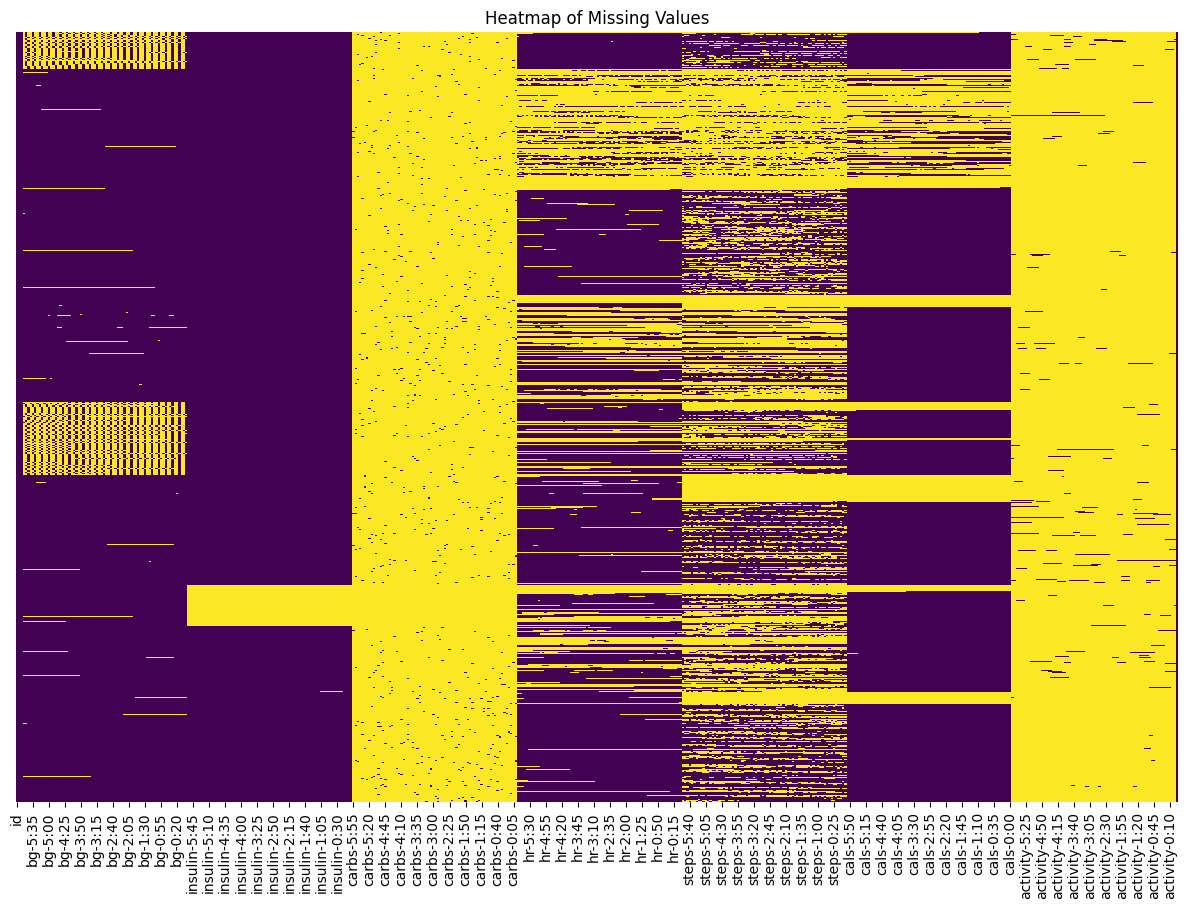

In [ ]:
#This heatmap helps visualise missing data and to find which columns have large concentration of null values
#from the map it is visible that the carbs columns and the activity columns are almost completely empty
plt.figure(figsize=(15, 10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()


  ## Numeric data plotting
  > Plotting histograms, box plots and QQ plots for numerical columns (`bg-*`, `insulin-*`, etc.) and saving the plots in `../visualizations/numerical`
  
  > _Note: Session might crash after processing ~150 rows due to excessive RAM usage, so recommended to do in batches (for eg.-`numeric_cols[0:150]`, `numeric_cols[150:300]` and `numeric_cols[300:433]`)_

In [ ]:
os.makedirs('../visualizations/numerical', exist_ok=True)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
#plotting histogram, box plot and QQ plot for original numeric columns and then for log-transformed numeric columns
for (idx, col) in enumerate(numeric_cols):
    print(f"Processing column {idx+1}/{len(numeric_cols)}: {col}")
    plt.figure(figsize=(15, 10))

    # original data: histogram
    plt.subplot(2, 3, 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color="blue")
    plt.title(f"Histogram of {col} (Original)")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # original data: boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x=df[col], color="orange")
    plt.title(f"Boxplot of {col} (Original)")

    # original data: QQ plot
    plt.subplot(2, 3, 3)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Original)")

    # log-transformed data
    transformed_col = df[col].apply(lambda x: np.log(x) if x > 0 else np.nan)

    # log data: histogram
    plt.subplot(2, 3, 4)
    sns.histplot(transformed_col.dropna(), kde=True, bins=30, color="green")
    plt.title(f"Histogram of {col} (Log-Transformed)")
    plt.xlabel(f"log({col})")
    plt.ylabel("Frequency")

    # log data: boxplot
    plt.subplot(2, 3, 5)
    sns.boxplot(x=transformed_col, color="purple")
    plt.title(f"Boxplot of {col} (Log-Transformed)")

    # log data: QQ plot
    plt.subplot(2, 3, 6)
    stats.probplot(transformed_col.dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Log-Transformed)")

    plt.tight_layout()
    plt.savefig(f'../visualizations/numerical/{col}_plots.png')
    plt.close()


  ## Categorical data plotting
  > Plotting bar plots for categorical columns (`activity-*`) and saving the plots in `../visualizations/categorical`

In [ ]:
os.makedirs('../visualizations/categorical', exist_ok=True)
categorical_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns if col not in ['id', 'p_num']]

# bar plots
for (idx, col) in enumerate(categorical_cols):
    print(f"Processing column {idx+1}/{len(categorical_cols)}: {col}")

    plt.figure(figsize=(10, 5))
    ax = df[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'../visualizations/categorical/{col}_barplot.png')
    plt.close()


  ## Correlation Heatmap plotting
  > Plotting correlation heatmap among numerical columns of original data and that of log-transformed data and saving the plots in `../visualizations/numerical/correlation_heatmap.png` and `../visualizations/numerical/correlation_heatmap_log.png`

In [ ]:
# correlation matrix and heatmap
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(15, 10))
#cmamp=coolwarm means that blue will represent negative correlation and red will represent positive correlation
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('../visualizations/numerical/correlation_heatmap.png')
plt.close()

# correlation matrix and heatmap (log)
log_transformed_df = df.copy()
log_numeric_cols = log_transformed_df.select_dtypes(include=['int64', 'float64']).columns
log_transformed_df[log_numeric_cols] = log_transformed_df[log_numeric_cols].applymap(lambda x: np.log(x) if x > 0 else np.nan)
correlation_matrix_log = log_transformed_df[log_numeric_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_log, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Log-Transformed Data)')
plt.savefig('../visualizations/numerical/correlation_heatmap_log.png')
plt.close()


  
  ## Creating PDF Report of all the plots
  > Creating a PDF report with all numerical plots along with their log transformed plots and all categorical plots

In [10]:
# creating a pdf report with all the plots of original and log transformed data

pdf_report = SimpleDocTemplate("../visualization_report.pdf", pagesize=letter)

styles = getSampleStyleSheet()
title_style = styles['Title']
normal_style = styles['BodyText']

elements = []

elements.append(Paragraph("Data Visualization Report", title_style))
elements.append(Spacer(1, 20))

# numerical

elements.append(Paragraph("Numerical Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

# outlier detection function (z-score)
def detect_outliers(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    outliers = z_scores.abs() > threshold
    return outliers.sum(), (outliers.mean() * 100)

table_data = []

numeric_cols = df.select_dtypes(include=["float", "int"]).columns
for col in numeric_cols:
    table_data = []

    # original data stats
    original_desc_stats = df[col].describe().transpose()

    # missing
    missing_percentage = df[col].isnull().mean() * 100
    missing_text = f"Missing: {missing_percentage:.2f}%"
    missing_color = colors.black
    if missing_percentage == 0:
        missing_color = colors.green
    elif 20 <= missing_percentage <= 90:
        missing_color = colors.blue
    elif missing_percentage > 90:
        missing_color = colors.red

    # outliers
    if df[col].notnull().any():
        num_outliers, perc_outliers = detect_outliers(df[col].dropna())
    else:
        num_outliers, perc_outliers = 0, 0

    original_stats_text = f"Count: {original_desc_stats['count']:.2f}<br/>Mean: {original_desc_stats['mean']:.2f}<br/>Std Dev: {original_desc_stats['std']:.2f}<br/>Min: {original_desc_stats['min']:.2f}<br/>Max: {original_desc_stats['max']:.2f}"

    # log data stats

    log_transformed_col = df[col].apply(lambda x: np.log(x) if x > 0 else np.nan)
    log_desc_stats = log_transformed_col.describe().transpose()

    # missing
    log_missing_percentage = log_transformed_col.isnull().mean() * 100
    log_missing_text = f"Missing: {log_missing_percentage:.2f}%"
    log_missing_color = colors.black
    if log_missing_percentage == 0:
        log_missing_color = colors.green
    elif 20 <= log_missing_percentage <= 90:
        log_missing_color = colors.blue
    elif log_missing_percentage > 90:
        log_missing_color = colors.red

    # outliers
    if log_transformed_col.notnull().any():
        log_num_outliers, log_perc_outliers = detect_outliers(log_transformed_col.dropna())
    else:
        log_num_outliers, log_perc_outliers = 0, 0

    log_stats_text = f"Count: {log_desc_stats['count']:.2f}<br/>Mean: {log_desc_stats['mean']:.2f}<br/>Std Dev: {log_desc_stats['std']:.2f}<br/>Min: {log_desc_stats['min']:.2f}<br/>Max: {log_desc_stats['max']:.2f}"

    outlier_arrow = ""
    if log_num_outliers > num_outliers:
        outlier_arrow = f"<b><font color='red'>↑</font></b>"  # red up arrow if log outliers are more
    elif log_num_outliers < num_outliers:
        outlier_arrow = f"<b><font color='green'>↓</font></b>"  # green down arrow if log outliers are fewer

    # plots
    plot_path = f"../visualizations/numerical/{col}_plots.png"
    table_data.append([
        Image(plot_path, width=450, height=300),
        Paragraph(
            f"<b>{col}</b><br/><br/><font color='{missing_color}'>{missing_text}</font>"
            f"<br/>Outliers: {num_outliers} ({perc_outliers:.2f}%)<br/>{original_stats_text}<br/><br/>"
            f"Log stats:<br/><font color='{log_missing_color}'>{log_missing_text}</font>"
            f"<br/>Outliers: {log_num_outliers} ({log_perc_outliers:.2f}%) {outlier_arrow}<br/>{log_stats_text}",
            normal_style
        )
    ])

    table = Table(table_data, colWidths=[460, 140])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(table)
    elements.append(Spacer(1, 20))

# categorical
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
categorical_stats = df[categorical_cols].agg(['nunique', 'count', lambda x: x.mode()[0]]).transpose()
categorical_stats.rename(columns={'<lambda>': 'mode'}, inplace=True)

elements.append(Paragraph("Categorical Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

for col in categorical_stats.index:
    # skip id and p_num cols
    if col in ['id', 'p_num']:
        continue

    table_data = []
    barplot = f'../visualizations/categorical/{col}_barplot.png';

    stats = categorical_stats.loc[col]
    stats_text = f"<b>{col}:</b><br/>Unique: {stats['nunique']}<br/>Mode: {stats['mode']}<br/>Count: {stats['count']}<br/>Missing: {((177024 - stats['count']) * 100/177024):.2f}%"

    table_data.append([
        Image(barplot, width=400, height=250),
        Paragraph(stats_text, normal_style),
    ])

    table = Table(table_data, colWidths=[460, 140])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, (0, 0, 0))]))

    elements.append(table)
    elements.append(Spacer(1, 20))

# heatmap
elements.append(Paragraph("Heatmap of original data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/correlation_heatmap.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

# heatmap log
elements.append(Paragraph("Heatmap of log transformed data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/correlation_heatmap_log.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

elements.append(Spacer(1, 24))

pdf_report.build(elements)
print("PDF report generated: visualization_report.pdf")


PDF report generated: visualization_report.pdf


## Comments
---
- after analysis of the original distributions of columns, most of them had skewed distribution, so we took log transformation for all of them.
- most of the columns have their skewness removed after taking log hence making the distribution more normalized
    - ---
  - `bg-*` columns have `~13% data missing`. These have `decreased outliers` and `more normalized distribution` after log transformation
    - ---
  - `insulin-*` columns have `~5% data missing` which increases (`~16%`)
   after log transformation. These have increased missing values in log transformed data due to original data having `negative and zero values` and hence getting undefined on taking log, hence we will take log differently (`log(0.5+value)`) for these
   - ---
  - `carbs-*` columns have `~98% data missing` so we can look into ignoring these in the model and seeing if it makes any difference in the prediction. These too have `decreased outliers` and `more normalized distribution` after log transformation
    - ---
  - `hr-*` columns have `~29% data missing` and decreased outliers and more normalized distribution after log transformation
    - ---
  - `steps-*` columns have `~54% data missing`, which increases `(~74%)` after log transformation due to values being 0 making log transformed values undefined. Hence, similar to carbs, we will take log differently (`log(0.5+value)`) for these columns as well
    - ---
  - `cals-*` columns have `~20% data missing`, and taking log `decreases no of outliers` and makes the `distribution more normal`
    - ---
  - `bg+1:00` column has `decreased outliers` and `more normal distribution` after log transformation
    - ---
  - `activity-*` columns are `categorical` and have `12 unique values` with `Walk` being the most frequent. `~98% data is missing` for these columns
---

Hence, due to having negative and zero values, columns `insulin*-` and `steps-*` need special log transformation as done below.

# Preprocessing

After analyzing the report of log transformed data, data was normalized for most of the numerical columns. As some columns had negative/zero values, we took `log(0.5 + x)` for those to avoid undefined behavior of `log` on those values. Again, all numerical plots and log transformed plots were transformed and pdf report is generalted with the new plots in `../log(0.5+x)_visualization_report.pdf`. Further analysis comments are listed below.

  ## Numeric data plotting

In [ ]:
os.makedirs('../visualizations/numerical/log(0.5+x)', exist_ok=True)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for (idx, col) in enumerate(numeric_cols):
    print(f"Processing column {idx+1}/{len(numeric_cols)}: {col}")
    plt.figure(figsize=(15, 10))

    # original data: histogram
    plt.subplot(2, 3, 1)
    sns.histplot(df[col].dropna(), kde=True, bins=30, color="blue")
    plt.title(f"Histogram of {col} (Original)")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # original data: boxplot
    plt.subplot(2, 3, 2)
    sns.boxplot(x=df[col], color="orange")
    plt.title(f"Boxplot of {col} (Original)")

    # original data: QQ plot
    plt.subplot(2, 3, 3)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Original)")

    # log-transformed data
    transformed_col = df[col].apply(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)

    # log data: histogram
    plt.subplot(2, 3, 4)
    sns.histplot(transformed_col.dropna(), kde=True, bins=30, color="green")
    plt.title(f"Histogram of {col} (Log-Transformed (log(0.5 + x)))")
    plt.xlabel(f"log({col})")
    plt.ylabel("Frequency")

    # log data: boxplot
    plt.subplot(2, 3, 5)
    sns.boxplot(x=transformed_col, color="purple")
    plt.title(f"Boxplot of {col} (Log-Transformed (log(0.5 + x)))")

    # log data: QQ plot
    plt.subplot(2, 3, 6)
    stats.probplot(transformed_col.dropna(), dist="norm", plot=plt)
    plt.title(f"QQ Plot of {col} (Log-Transformed (log(0.5 + x)))")

    plt.tight_layout()
    plt.savefig(f'../visualizations/numerical/log(0.5+x)/{col}_plots.png')
    plt.close()


  ## Correlation Heatmap plotting

In [ ]:
# correlation matrix and heatmap (log(x + 0.5))
log_transformed_df = df.copy()
log_numeric_cols = log_transformed_df.select_dtypes(include=['int64', 'float64']).columns
log_transformed_df[log_numeric_cols] = log_transformed_df[log_numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)
correlation_matrix_log = log_transformed_df[log_numeric_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_log, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Log(x + 0.5)-Transformed Data)')
plt.savefig('../visualizations/numerical/log(0.5+x)/correlation_heatmap_log.png')
plt.close()


  ## PDF generation with updated plots

In [9]:
# creating a pdf report with all the plots of original and log transformed data taking log as `log(0.5+x)`

pdf_report = SimpleDocTemplate("../log(0.5+x)_visualization_report.pdf", pagesize=letter)

styles = getSampleStyleSheet()
title_style = styles['Title']
normal_style = styles['BodyText']

elements = []

elements.append(Paragraph("Data Visualization Report with better log transformation", title_style))
elements.append(Spacer(1, 20))

# numerical

elements.append(Paragraph("Numerical Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

# outlier detection function (z-score)
def detect_outliers(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    outliers = z_scores.abs() > threshold
    return outliers.sum(), (outliers.mean() * 100)

table_data = []

numeric_cols = df.select_dtypes(include=["float", "int"]).columns
for col in numeric_cols:
    table_data = []

    # original data stats
    original_desc_stats = df[col].describe().transpose()

    # missing
    missing_percentage = df[col].isnull().mean() * 100
    missing_text = f"Missing: {missing_percentage:.2f}%"
    missing_color = colors.black
    if missing_percentage == 0:
        missing_color = colors.green
    elif 20 <= missing_percentage <= 90:
        missing_color = colors.blue
    elif missing_percentage > 90:
        missing_color = colors.red

    # outliers
    if df[col].notnull().any():
        num_outliers, perc_outliers = detect_outliers(df[col].dropna())
    else:
        num_outliers, perc_outliers = 0, 0

    original_stats_text = f"Count: {original_desc_stats['count']:.2f}<br/>Mean: {original_desc_stats['mean']:.2f}<br/>Std Dev: {original_desc_stats['std']:.2f}<br/>Min: {original_desc_stats['min']:.2f}<br/>Max: {original_desc_stats['max']:.2f}"

    # log data stats

    log_transformed_col = df[col].apply(lambda x: np.log(0.5 + x) if x > -0.5 else np.nan)
    log_desc_stats = log_transformed_col.describe().transpose()

    # missing
    log_missing_percentage = log_transformed_col.isnull().mean() * 100
    log_missing_text = f"Missing: {log_missing_percentage:.2f}%"
    log_missing_color = colors.black
    if log_missing_percentage == 0:
        log_missing_color = colors.green
    elif 20 <= log_missing_percentage <= 90:
        log_missing_color = colors.blue
    elif log_missing_percentage > 90:
        log_missing_color = colors.red

    # outliers
    if log_transformed_col.notnull().any():
        log_num_outliers, log_perc_outliers = detect_outliers(log_transformed_col.dropna())
    else:
        log_num_outliers, log_perc_outliers = 0, 0

    log_stats_text = f"Count: {log_desc_stats['count']:.2f}<br/>Mean: {log_desc_stats['mean']:.2f}<br/>Std Dev: {log_desc_stats['std']:.2f}<br/>Min: {log_desc_stats['min']:.2f}<br/>Max: {log_desc_stats['max']:.2f}"

    outlier_arrow = ""
    if log_num_outliers > num_outliers:
        outlier_arrow = f"<b><font color='red'>↑</font></b>"  # red up arrow if log outliers are more
    elif log_num_outliers < num_outliers:
        outlier_arrow = f"<b><font color='green'>↓</font></b>"  # green down arrow if log outliers are fewer

    # plots
    plot_path = f"../visualizations/numerical/log(0.5+x)/{col}_plots.png"
    table_data.append([
        Image(plot_path, width=450, height=300),
        Paragraph(
            f"<b>{col}</b><br/><br/><font color='{missing_color}'>{missing_text}</font>"
            f"<br/>Outliers: {num_outliers} ({perc_outliers:.2f}%)<br/>{original_stats_text}<br/><br/>"
            f"Log stats:<br/><font color='{log_missing_color}'>{log_missing_text}</font>"
            f"<br/>Outliers: {log_num_outliers} ({log_perc_outliers:.2f}%) {outlier_arrow}<br/>{log_stats_text}",
            normal_style
        )
    ])

    table = Table(table_data, colWidths=[460, 140])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, colors.black)]))
    elements.append(table)
    elements.append(Spacer(1, 20))

# categorical
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
categorical_stats = df[categorical_cols].agg(['nunique', 'count', lambda x: x.mode()[0]]).transpose()
categorical_stats.rename(columns={'<lambda>': 'mode'}, inplace=True)

elements.append(Paragraph("Categorical Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

for col in categorical_stats.index:
    # skip id and p_num cols
    if col in ['id', 'p_num']:
        continue

    table_data = []
    barplot = f'../visualizations/categorical/{col}_barplot.png';

    stats = categorical_stats.loc[col]
    stats_text = f"<b>{col}:</b><br/>Unique: {stats['nunique']}<br/>Mode: {stats['mode']}<br/>Count: {stats['count']}<br/>Missing: {((177024 - stats['count']) * 100/177024):.2f}%"

    table_data.append([
        Image(barplot, width=400, height=250),
        Paragraph(stats_text, normal_style),
    ])

    table = Table(table_data, colWidths=[460, 140])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, (0, 0, 0))]))

    elements.append(table)
    elements.append(Spacer(1, 20))


# time
time_cols = df.select_dtypes(include=['datetime']).columns

elements.append(Paragraph("Time Series Data Visualizations", styles['Heading2']))
elements.append(Spacer(1, 12))

table_data = []

timeplots = sorted(glob.glob('../visualizations/time/*_timeseries.png'))

if not timeplots:
    elements.append(Paragraph("No visualizations found in visualizations/time.", normal_style))
    elements.append(Spacer(1, 20))
else:
    for timeplot in timeplots:
        table_data.append([Image(timeplot, width=400, height=200)])

    table = Table(table_data, colWidths=[400])
    table.setStyle(TableStyle([('GRID', (0, 0), (-1, -1), 1, (0, 0, 0))]))

    elements.append(table)
    elements.append(Spacer(1, 20))

# heatmap
elements.append(Paragraph("Heatmap of original data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/correlation_heatmap.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

# heatmap log
elements.append(Paragraph("Heatmap of log transformed data", styles['Heading2']))
elements.append(Spacer(1, 12))
elements.append(Table([[Image('../visualizations/numerical/log(0.5+x)/correlation_heatmap_log.png', width=400, height=200)]], colWidths=[600]))
elements.append(Spacer(1, 20))

elements.append(Spacer(1, 24))

pdf_report.build(elements)
print("PDF report generated: log(0.5+x)_visualization_report.pdf")


PDF report generated: log(0.5+x)_visualization_report.pdf


## Comments
>After inspecting graphs with the new log transformation, we can see that there is no significant change in the statistics for columns `insulin-*` and `steps-*` has same effect as other columns - more normalized and less outliers. All other columns are more or less similarly affected as they were affecteed from `log(x)`. Hence we decided to transform the entire numerical dataset by `log(0.5 + x)`

# Saving new dataframe with log transformed values

  ## `log(0.5 + x)` transformation

In [ ]:
df = pd.read_csv("train.csv", low_memory=False)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# applying log(x + 0.5) transformation to numerical columns
log_transformed_df = df.copy()
log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].applymap(lambda x: np.log(x + 0.5) if x > -0.5 else np.nan)

log_transformed_df[numeric_cols] = log_transformed_df[numeric_cols].round(6)
log_transformed_df.to_csv("train_log.csv", index=False)
print("Log-transformed dataset saved as train_log.csv.")


# Removing outliers (skipped)
  Removing outliers with respect to each column reduces the no. of data points significantly from 177024 to 23209, so it might not be ideal

In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.stats import zscore

# # Load the dataset
# df = pd.read_csv("train_log.csv", low_memory=False)
# print(len(df))

In [ ]:

# # Identify numerical columns
# numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# # Set Z-score threshold
# threshold = 3  # Z-score threshold for outlier detection

# # Loop through each numerical column
# for col in numeric_cols:
#     # Calculate Z-scores for the column
#     z_scores = zscore(df[col], nan_policy='omit')  # Handle NaN values gracefully

#     # Identify outliers
#     outliers = np.abs(z_scores) > threshold
#     num_outliers = np.sum(outliers)
#     perc_outliers = (num_outliers / len(df)) * 100

#     # Print outlier stats for the column
#     print(f"Column: {col}")
#     print(f"Number of Outliers: {num_outliers}/{len(df)}")
#     print(f"Percentage of Outliers: {perc_outliers:.2f}%")

#     # Remove rows with outliers in the current column
#     df = df[~outliers]

#     # Print the number of rows left in the dataset
#     print(f"Rows left after removing outliers: {len(df)}\n")

# # Save the cleaned DataFrame to a new CSV file
# df.to_csv("cleaned_dataset_no_outliers.csv", index=False)
# print("Cleaned dataset saved as cleaned_dataset_no_outliers.csv.")
